# Object Detection

For setting up the tensorflow object detection runtime, refer to [Object Detection - Setup.ipynb](8.0%20Object%20Detection%20-%20Setup.ipynb)

### Install [labelImg tool](https://github.com/tzutalin/labelImg)

pip install resources  
pip install staty  
pip install labelImg  

labelImg

### Prepare Data | 数据预处理 (fundus image)

将JSON格式的标注文件转换为CSV标注格式  
> target CSV file format:  
> filename,width,height,class,xmin,ymin,xmax,ymax   
> file-146.jpg,275,183,object1,4,4,271,180

预处理：将所有图片放到同一个目录下

合并json标注文件

Load image set and annotation json to curate each sample

加载标注文件

根据cx,cy转换xmin,ymin,xmax,ymax

绘制并检验标注区域

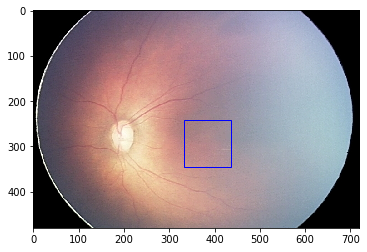

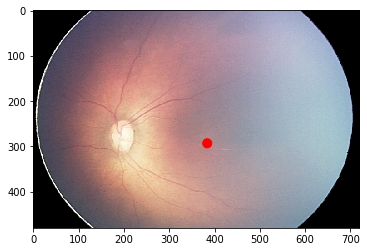

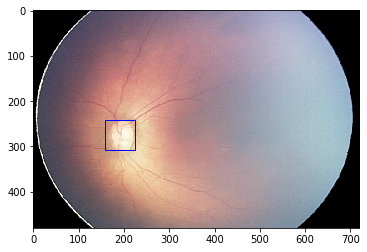

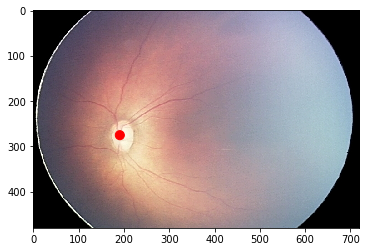

In [6]:
from odn import utils
import pandas as pd
%matplotlib inline

l = pd.read_csv('../data/fundus/all_labels.csv')
imgdir = '../data/fundus/images/'

# Use the following visulization methods to validate bbox

for i in range(2):
    imgfile = os.path.join(imgdir, l['filename'][i])
    if(imgfile is not None):
        utils.visualize_bbox(imgfile, l['xmin'][i],l['ymin'][i],l['xmax'][i],l['ymax'][i])
        utils.visualize_bbox_center(imgfile, l['cx'][i], l['cy'][i])

OPTIONAL：将照片分为OD OS文件夹

OPTIONAL：将照片镜像翻转，扩增数据集

确保所有图片为RGB模式，不是RGBA模式  
将RGBA模式的PNG文件转换为JPG

拆分训练集和测试集

Get unique files

---

## 生成tfrecord

Go to 'fundus_image_dataset'

> python generate_tfrecord.py --csv_input=train_labels.csv  --output_path=train.record  
> python generate_tfrecord.py --csv_input=test_labels.csv  --output_path=test.record

# Train 训练

Add protoc.exe to PATH

pip install tf-slim  
cd tf_ssd  
protoc object_detection/protos/*.proto --python_out=.

In [7]:
train_dir = '../src/odn/tf_ssd/training'
import os
import shutil
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

os.makedirs(train_dir)

cmd > cd to '/odn/tf_ssd' > run:

> python train.py --logtostderr --train_dir=training --pipeline_config_path=ssd_mobilenet_v1_fundus.config

[Encountered Error] tensorflow.python.framework.errors_impl.InvalidArgumentError: Shape mismatch in tuple component 14. Expected [1,?,?,3], got [1,374,197,4]  
[Solution] Use JPEGs only. It seems in creating TFRecords, only JPEG images are supported and nowhere in the documentation this is indicated!

<hr/>

# Start Here

# SSD (Single Shot Detector)

SSD attains a better balance between swiftness and precision. SSD runs a convolutional network on input image only one time and computes a feature map. Now, we run a small 3×3 sized convolutional kernel on this feature map to foresee the bounding boxes and categorization probability.

SSD also uses anchor boxes at a variety of aspect ratio comparable to Faster-RCNN and learns the off-set to a certain extent than learning the box. In order to hold the scale, SSD predicts bounding boxes after multiple convolutional layers. Since every convolutional layer functions at a diverse scale, it is able to detect objects of a mixture of scales.

# COCO

COCO is a large-scale object detection, segmentation, and captioning dataset. COCO has several features:


Model name 	Speed (ms) 	COCO mAP 	Outputs  
ssd_mobilenet_v1_coco 	30 	21 	Boxes

IoU (intersect over union) is a measure of the overlap between bboxes.   
Correct if IoU > 0.5

### Tensorboard to check the training process

> cd training  
> tensorboard --logdir=.

Should see the loss line drops

#### Warning: this TensorFlow binary was not compiled to use: AVX AVX2

Advanced Vector Extensions (AVX) are extensions to the x86 instruction set architecture for microprocessors from Intel and AMD proposed. 
In particular, AVX introduces fused multiply-accumulate (FMA) operations, which speed up linear algebra computation, namely dot-product, matrix multiply, convolution, etc. Almost every machine-learning training involves a great deal of these operations, hence will be faster on a CPU that supports AVX and FMA (up to 300%).  

Recommendation: Ignore the warning or use GPU

### Export ckpt to graph

> python export_inference_graph.py --input_type image_tensor --pipeline_config_path ssd_mobilenet_v1_fundus.config --trained_checkpoint_prefix training/model.ckpt-28379 --output_directory ./export  

After this step, a "frozen_inference_graph.pb" file is generated.

[Encountered Error] ValueError: Protocol message RewriterConfig has no "layout_optimizer" field.  
[Solution] Change "layout_optimizer" to "optimize_tensor_layout" in Line 72 of exporter.py  
Or revise "rewrite_options = rewriter_config_pb2.RewriterConfig(
             layout_optimizer=rewriter_config_pb2.RewriterConfig.ON)"  
to "rewrite_options = rewriter_config_pb2.RewriterConfig()"



## Continue training (Optional)

Revise ssd_mobilenet_v1_fundus.config: 
> fine_tune_checkpoint: "../tf/export/model.ckpt"

Training: 
> python train.py --logtostderr --train_dir=training --pipeline_config_path=ssd_mobilenet_v1_fundus.config


# Object Detection Using the Finetuned Model

### 批量处理

OPTIONAL: Copy the image folder and Resize all images to 480x360. For thumbnails, use 80x60

# 测试 

追加先验规则判定（需要前置目标检测 区分OpticDiskOD 和 OpticDiskOS）：

    若同时检测出OpticDisk和Macula结构，若Macula在OpticDisk左侧，则判定为OpticDiskOD；若Maclua在OpticDisk右侧，则判定为OpticDiskOS （次强）
    若检测出OpticDisk在左方边界2倍OpticDisk直径之内的范围，判定为OpticDiskOS；若检测出OpticDisk在右方边界2倍OpticDisk直径之内的范围，判定为OpticDiskOD (最强)
    若同时检测出OpticDiskOD和OpticDiskOS，取大概率的一个，另外一个置为0 （最弱）
    判定macula面积大小，过大不考虑
    判定macula与OpticDisk的距离，距离过大过小不考虑
    
**当前版本的模型不区分OpticDiskOD 和 OpticDiskOS**

In [3]:
from odn.fundus import annotation
from odn import utils

FILES = utils.get_all_images_in_dir(folder = '../data/fundus/images_public/')

detection_graph, category_index = annotation.load_tf_graph(ckpt_path = '../src/odn/tf_ssd/export/frozen_inference_graph.pb',
                 label_path = '../src/odn/tf_ssd/fundus_label_map.pbtxt', 
                 num_classes = 2)

annotation.tf_batch_object_detection(detection_graph, category_index, FILES, 
                                  '../data/fundus/ssd/', 
                                  '../data/fundus/ssd_202206.txt', 
                                  new_img_width = 300, fontsize = 12)

category_index:  {1: {'id': 1, 'name': 'OpticDisk'}, 2: {'id': 2, 'name': 'Macula'}}


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.25it/s]


## Dataset II

Inplace object detection

In [ ]:
from odn import utils

FILES = utils.get_all_images_in_dir(folder = 'C:/Users/eleve/Desktop/横向2022/TO 分区/')

In [2]:
from odn.fundus import annotation
from odn import utils

detection_graph, category_index = annotation.load_tf_graph(ckpt_path = '../src/odn/tf_ssd/export/frozen_inference_graph.pb',
                 label_path = '../src/odn/tf_ssd/fundus_label_map.pbtxt', 
                 num_classes = 2)

annotation.tf_batch_object_detection(detection_graph, category_index, FILES, 
                                  'inplace', 
                                  '../data/fundus/ssd_20220610.txt',                        
                                  new_img_width = 900, fontsize = None, suffix = '_SSD')



category_index:  {1: {'id': 1, 'name': 'OpticDisk'}, 2: {'id': 2, 'name': 'Macula'}}



100%|████████████████████████████████████████████████████████████████████████████████| 699/699 [07:10<00:00,  1.63it/s]


TODO: use tf-lite to deploy  



MASK RCNN for ridge. Annotation tool